## In this project, I will scale my previous prototype with Keras and Dask.

In [1]:
import numpy as np
import pandas as pd
import dask
import dask.dataframe as dd

In [2]:
base = pd.read_csv('kc_house_data.csv')
base.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
X = base.iloc[:,[3,4,5,6,7,11,12,13,14,17,18]]
X.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_built,lat,long
0,3,1.00,1180,5650,1.0,7,1180,0,1955,47.5112,-122.257
1,3,2.25,2570,7242,2.0,7,2170,400,1951,47.7210,-122.319
2,2,1.00,770,10000,1.0,6,770,0,1933,47.7379,-122.233
3,4,3.00,1960,5000,1.0,7,1050,910,1965,47.5208,-122.393
4,3,2.00,1680,8080,1.0,8,1680,0,1987,47.6168,-122.045


In [4]:
y = base.iloc[:,2]
y.head()

0    221900.0
1    538000.0
2    180000.0
3    604000.0
4    510000.0
Name: price, dtype: float64

In [5]:
X = X.values
y = y.values.reshape(-1,1)

## Scale the data

In [6]:
%%time
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y)

CPU times: user 253 ms, sys: 59.3 ms, total: 312 ms
Wall time: 318 ms


## Split the dataset into training and testing

In [7]:
from sklearn.model_selection import train_test_split
X_treinamento, X_teste, y_treinamento, y_teste = \
train_test_split(X, y, test_size=.2, random_state=0)

In [8]:
# Import Keras modules
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error

Using TensorFlow backend.
/usr/local/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Build the network and fit the model in a loop with diferent learning rates
Loss function values are stored in a dictionary for later plotting. MAEis also calculated with the testing dataset for each iteration.

In [10]:
%%time
dic_loss = {}
lr_ = []
mae_ = []

lr_list = [.000001,.000005,.00001,.00005,.0001,.0005,.001,.005,.01,.05]
count = 0

for lr in lr_list:
    
    print('lr =',lr)
    count += 1
    print(str(count)+'/'+str(len(lr_list)))

    opt = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
    model = Sequential()
    model.add(Dense(6, input_dim=11, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=opt, metrics=['mse','mae'])
    history = model.fit(X_treinamento, y_treinamento, epochs=100, verbose=0, batch_size=25)
    
    previsoes = model.predict(X_teste)

    previsoes = scaler_y.inverse_transform(previsoes)
    #y_teste = scaler_y.inverse_transform(y_teste)

    mae = mean_absolute_error(scaler_y.inverse_transform(y_teste), previsoes)
    
    dic_loss[str(lr)] = history.history['loss']
    lr_.append(lr)
    mae_.append(mae)

lr = 1e-06
1/10
lr = 5e-06
2/10
lr = 1e-05
3/10
lr = 5e-05
4/10
lr = 0.0001
5/10
lr = 0.0005
6/10
lr = 0.001
7/10
lr = 0.005
8/10
lr = 0.01
9/10
lr = 0.05
10/10
CPU times: user 21min 55s, sys: 1min 15s, total: 23min 11s
Wall time: 14min 8s


CPU and Wall time are relatively long here. If this model is built with a much larger data (say 10 times bigger), we can imagine the time needed for this step will also be considerably longer.

## Plotting loss values and the MAE for each learning rate

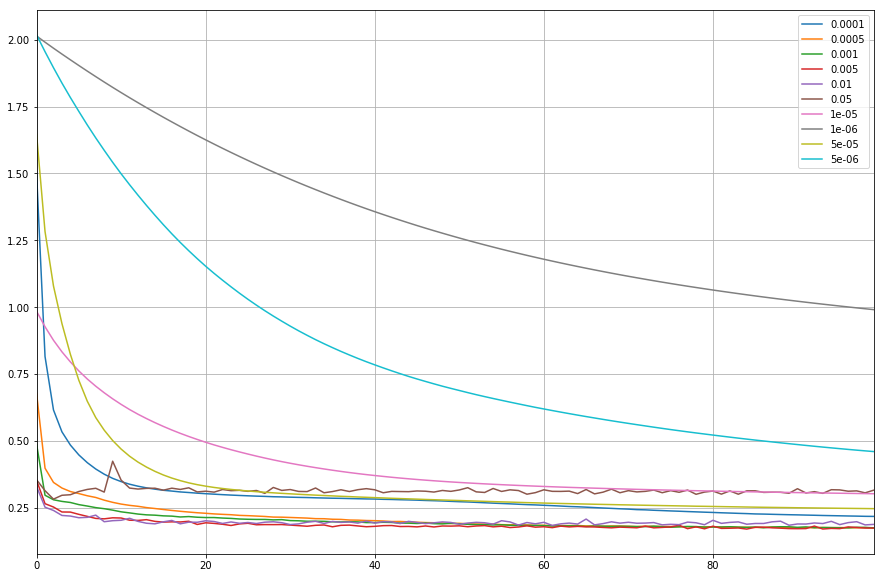

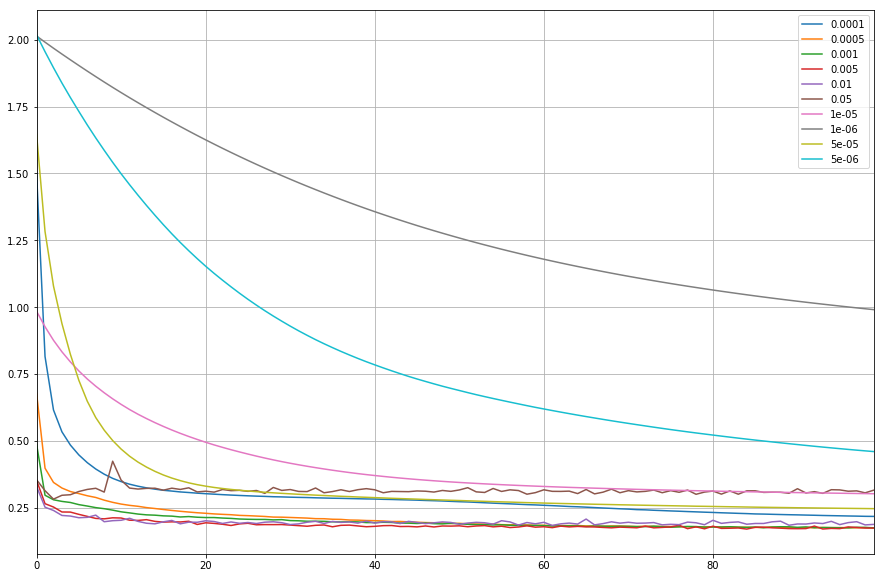

In [15]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

df = pd.DataFrame(dic_loss)
df.plot().grid()
plt.show()

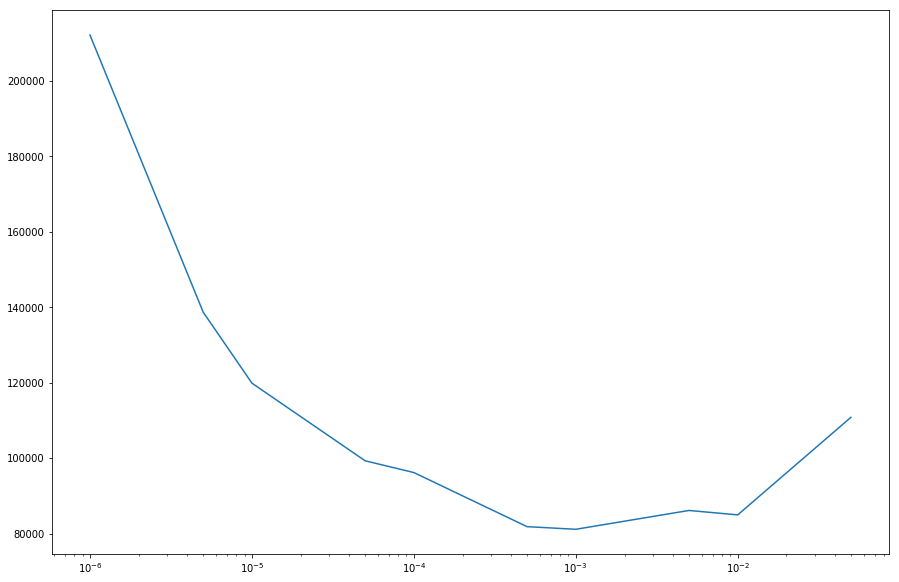

In [16]:
plt.semilogx(lr_, mae_)
plt.show()

As can be seen, lr=0.001 is a good value for this problem, since the conversion is fast and the MAE is low.